# ANÁLISIS BIVARIADO DE SERIES DE TIEMPO (BITCOIN Y ETHEREUM) USANDO REDES RNN-LSTM A UN PASO

#### Análisis bidimensional (bivariado) y a un paso de las series de tiempo del precio de Bitcoin y del Ethereum.

<a name="contents"></a>
# Contenido

- [Notas, desconexión y librerías](#conecct)
- [Importando y visualizando datos del Bitcoin y Ethereum](#data)
- [Selección y visualización de datos a tratar](#select&PlottingData)
- [Definiendo hiperparámetros y estandarizando los datos](#hyper&Standard)
- [Función de preparación de datos (multivariate_data)](#multivariate_data)
- [Distribución de los datos (entrenamiento y validación) y transformación de estos al formato de TensorFlow](#Distr&TFFormat)
- [Funciones para graficar predicción y pérdida](#plotFuncts)
- [Función(es) de creación del modelo RNN-LSTM](#modelFunct)
- [PRIMEROS MODELOS: Con 8, 128 y 256 neuronas.](#1stModels)
- [Primeras gráficas: Graficando predicciones (de 8, 128 y 256 neuronas) y mostrando errores (MSE)](#1stPredPlots)
- [SEGUNDOS MODELOS (PROBLEMA): Predicciones de modelos "iguales" (con 128 y 512 neuronas)](#sameModels)
- [Caracterizando el error (MSE) con modelos bivariados de 256 neuronas ](#Errors)
- [Conclusiones e ideas](#Conclu)

<a name="conecct"></a>
# Notas, desconexión y librerías:
- La primera celda es un código que en teoría evita la desconexión de Colab.

Volver a [Tabla de contenidos](#contents).

In [ ]:
#Source: https://towardsdatascience.com/10-tips-for-a-better-google-colab-experience-33f8fe721b82#0d57
#Stop Colab from disconecting:
#ctl+shift+i -> console -> command lines:
#Ctrl+ Shift + i to open inspector view . Then goto console.

function ConnectButton(){
    console.log("Working"); 
    document.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);

### *Importando paquetes:*

In [ ]:
#To import data
#!pip install pandas_datareader #For COLAB #Use if yfinance does not work #import pandas_datareader.data as web
#installing yfinance (Colab)
!pip install yfinance
#pip install yfinance --upgrade --no-cache-dir
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()
#For Bootstrap
!pip install dc_stat_think
import dc_stat_think as dcst
#To use goodness fit test
from scipy import stats
import random
#Data managing
import numpy as np
import os
import pandas as pd
#To comparison forecasts
from sklearn.metrics import mean_squared_error
#Graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
#RNN
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

#I dont know for what are these packages
import seaborn as sns
import time
import gc
import sys

print(f"Tensorflow Version: {tf.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"System Version: {sys.version}")

#Setting figure size
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

     |████████████████████████████████| 6.3MB 14.0MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23919 sha256=6821749e41af66b85d6ad31fc3be14329b023cc09a90700c98b705428d3a4480
  Stored in directory: /root/.cache/pip/wheels/fe/a0/79/b73d4a0c535b421b88fc7b393936b371fabbfeaf979eca4050
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
Tensorflow Version: 2.5.0
Pandas Version: 1.1.5
Numpy Version: 1.19.5
System Version: 3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]


<a name="data"></a>
# Importando y visualizando datos del Bitcoin y Ethereum:
## Registros diarios (uno por día)
Como se puede ver hay se tienen 2160 registros diarios del Bitcoin y Ethereum desde el 2015 hasta la fecha, por eso la diferencia con los 2481 a analizar solo el Bitcoin, ya que el Ethereum no cotiza desde el 2014:

Volver a [Tabla de contenidos](#contents).

In [ ]:
#Bivariate time series
print("--------------------------DATA--------------------------")
#Import this data is redundant, because it is done later
#df_adj = pdr.get_data_yahoo(["BTC-USD", "ETH-USD"]).dropna()["Adj Close"]
data = pdr.get_data_yahoo(["BTC-USD", "ETH-USD"]).dropna()
features = data["Adj Close"]

print(type(features))
print("---------------------------Head & Tail----------------------------")
print(data.head(2))
print(features.head(2))
print(features.tail(2))
print("---------------------------Description----------------------------")
#NOTE: Check that index is date by default
print(type(features.index))
print(features.describe())
#df_adj.sort_index(ascending=False).head()

--------------------------DATA--------------------------
[*********************100%***********************]  2 of 2 completed
<class 'pandas.core.frame.DataFrame'>
---------------------------Head & Tail----------------------------
             Adj Close                 Close  ...     Open    Volume          
               BTC-USD   ETH-USD     BTC-USD  ...  ETH-USD   BTC-USD   ETH-USD
Date                                          ...                             
2015-08-07  279.584991  2.772120  279.584991  ...  2.83162  42484800  164329.0
2015-08-08  260.997009  0.753325  260.997009  ...  2.79376  58533000  674188.0

[2 rows x 12 columns]
               BTC-USD   ETH-USD
Date                            
2015-08-07  279.584991  2.772120
2015-08-08  260.997009  0.753325
                 BTC-USD      ETH-USD
Date                                 
2021-07-18  31796.810547  1895.552124
2021-07-19  30619.119141  1817.112915
---------------------------Description----------------------------


<a name="select&PlottingData"></a>

#Selección y visualización de datos a tratar.
### Seleccionando los datos de la serie de tiempo a analizar
- Seleccionando los datos de cierre.
- Gráfica de los datos de entrenamiento y validación.
- Extrayendo los valores del dataframe (se deja de trabajar con un dataframe, y se pasa a trabajar con un array).

Volver a [Tabla de contenidos](#contents).

[*********************100%***********************]  2 of 2 completed


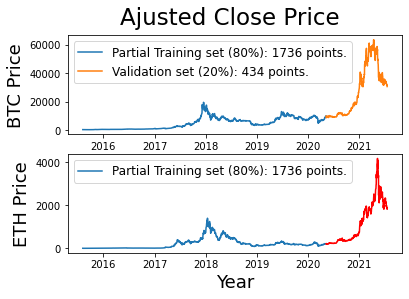

In [ ]:
#df_adj = pdr.get_data_yahoo(["BTC-USD", "ETH-USD"]).dropna()["Adj Close"]
data = pdr.get_data_yahoo(["BTC-USD", "ETH-USD"]).dropna()
features = data['Adj Close']

#Hiperparameter
TRAIN_SPLIT = int(len(features)*0.8)
#print(TRAIN_SPLIT)

#if it does not work, includ date as index
fig, axs = plt.subplots(2)
fig.suptitle("Ajusted Close Price", size=23)
#fig.suptitle("Precio de cierre ajustado", size=25)
#----- Bitcoin plot ---------
axs[0].set_ylabel('BTC Price', fontsize=18)
#axs[0].set_ylabel('Precio BTC (USD)', fontsize=18)
axs[0].plot(features['BTC-USD'][:TRAIN_SPLIT], label="Partial Training set (80%): "+str(TRAIN_SPLIT)+" points.")
axs[0].plot(features['BTC-USD'][TRAIN_SPLIT:], label="Validation set (20%): "+str(len(features)-TRAIN_SPLIT)+" points.")
#axs[0].plot(features['BTC-USD'][:TRAIN_SPLIT], label="Conjunto de entrenamiento parcial (80%): "+str(TRAIN_SPLIT)+" datos.")
#axs[0].plot(features['BTC-USD'][TRAIN_SPLIT:], label="Conjunto de validación (20%): "+str(len(features)-TRAIN_SPLIT)+" datos.")
axs[0].legend(fontsize = 12)
#----- Ethereum plot ---------
axs[1].set_ylabel('ETH Price', fontsize=18)
#axs[1].set_ylabel('Precio ETH (USD)', fontsize=18)
axs[1].plot(features['ETH-USD'][:TRAIN_SPLIT], label="Partial Training set (80%): "+str(TRAIN_SPLIT)+" points.")
#axs[1].plot(features['ETH-USD'][:TRAIN_SPLIT], label="Conjunto de entrenamiento parcial (80%): "+str(TRAIN_SPLIT)+" datos.")
axs[1].plot(features['ETH-USD'][TRAIN_SPLIT:], color="red")#, label="Validation set (20%): "+str(len(features)-TRAIN_SPLIT)+" points.")
axs[1].legend(fontsize = 12)
axs[1].set_xlabel('Year', fontsize = 18)
#axs[1].set_xlabel('Año', fontsize = 18)
plt.show()
#print(data.describe())


<a name="hyper&Standard"></a>
# Definiendo hiperparámetros (para la red LSTM) y estandarizando los datos
- *Idea:* Crear una función de estandarización para exportar).
- La estandarización se hace con los datos de entrenamiento.

Volver a [Tabla de contenidos](#contents).

In [ ]:
#-------------------- HYPERPARAMETERS ----------------------
#Data load params
BATCH_SIZE = 256
BUFFER_SIZE = 10000
#TRAIN_SPLIT = int(len(btc_usd)*0.8) #Put before
#print(TRAIN_SPLIT)
#print(type(TRAIN_SPLIT))


#LSTM params
EVALUATION_INTERVAL = 200 #FOR WHAT?
EPOCHS = 100
PATIENCE = 5 #FOR WHAT?

#Seeding for reproducibility
SEED = 13
tf.random.set_seed(SEED)

#-------------------- STANDARIZATION ----------------------
#Getting mean and std
dataset = features.values
#print(dataset)
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
#print(data_mean)
#print(data_std)

#standarized dataset
dataset = (dataset-data_mean)/data_std
#print(dataset)
#print(dataset.dtype)
#print(dataset[:,0]) #To understand 'target' in single step model


<a name="multivariate_data"></a>
# Función de preparación de datos (multivariate_data):
- Para análisis multivariado, datos ya estandarizados o normalizados.
- *Idea:* Candidata a exportar.

Volver a [Tabla de contenidos](#contents).

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
  '''
      dataset: Data "matrix" containing the all time series (stadarized or not)
      target: Data (point in single step model) to predict
      start_index: index from where data start to analize
      end_index: final index to take data. None is to take all data
      history_size: window size to create sequence (and then used to predict)
      target_size: position of point in future 'until where' (hasta donde) to predict
      step: (Provitional) step(1,2,etc) in indices to take data from dataset
      single_step: TRUE=>single step model FALSE=> multi step model
  '''
  data = []
  labels = []
  
  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size
  
  for i in range(start_index, end_index):
    indices = range(i-history_size,i,step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])
  
  return np.array(data), np.array(labels)

#print(len(range(0,10,2)))

In [ ]:
#Understanding 'STEP' (NOTE: STEP must be >= 1)
step_test = 1
#print(len(range(0,10,0)))
print(len(range(0,10,1)))
print(len(range(0,10,2)))

10
5


<a name="Distr&TFFormat"></a>
# Distribución de los datos (entrenamiento y validación) y transformación de estos al formato de TensorFlow 
- La distribución de los datos puede ser lo más importante de todo ya que define la cantidad de paramáteros y como se va a realizar la predicción.
- La transformación de los datos al formato de TF es para el uso de estos en la RNN-LSTM.

Volver a [Tabla de contenidos](#contents).

In [ ]:
#-------------------- TRAINING AND VALIDATION DATA ----------------------
#def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False)
past_history = 20
future_target = 1 #steps in future 'until where' to predict
STEP = 1#6

#training data
x_train_single_2D, y_train_single_2D = multivariate_data(dataset=dataset, target=dataset[:,0],
                                                   start_index=0, end_index=TRAIN_SPLIT, history_size = past_history,
                                                   target_size=future_target, step=STEP, single_step=True)

#validation data
x_val_single_2D, y_val_single_2D = multivariate_data(dataset=dataset, target=dataset[:,0],
                                               start_index=TRAIN_SPLIT, end_index=None, history_size = past_history,
                                               target_size=future_target, step=STEP, single_step=True)

#Checking shape
print(dataset.shape)
print(x_train_single_2D.shape)
print(x_train_single_2D.shape[-2:])
print(y_train_single_2D.shape)
print(x_train_single_2D.dtype)

#-------------------- DATA IN TENSORFLOW FORMAT ----------------------
#Train data
train_single_2D = tf.data.Dataset.from_tensor_slices((x_train_single_2D,y_train_single_2D))
train_single_2D = train_single_2D.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
#Validation data
val_single_2D = tf.data.Dataset.from_tensor_slices((x_val_single_2D,y_val_single_2D))
val_single_2D = val_single_2D.batch(BATCH_SIZE).repeat()

print(train_single_2D)
print(val_single_2D)
print(val_single_2D.take(1))

(2170, 2)
(1716, 20, 2)
(20, 2)
(1716,)
float64
<RepeatDataset shapes: ((None, 20, 2), (None,)), types: (tf.float64, tf.float64)>
<RepeatDataset shapes: ((None, 20, 2), (None,)), types: (tf.float64, tf.float64)>
<TakeDataset shapes: ((None, 20, 2), (None,)), types: (tf.float64, tf.float64)>


<a name="plotFuncts"></a>
# Funciones para graficar predicción y pérdida
- Función que grafica una predicción corta (de cada BATCH).
- Función que grafica la pérdida para los datos de entrenamiento y validación.
- *Candidatas a exportar* 

Volver a [Tabla de contenidos](#contents).

In [ ]:
def create_time_steps(length):
  return list(range(-length,0))

def plot_short_pred(plot_data, delta, title):
  #This function plots 3 things: History, true future and prediction
  '''
      plot_data (list): [x,y,z]: data to plot in function of time (time_steps).
      delta: (0 = False & 1 = True) I think related with 'univariate_future_target' 
      title (str): plot title.
  '''
  #print(type(plot_data))
  #print(plot_data[0])
  #print(plot_data[0].flatten())
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  #print(plot_data[0].shape[0])
  #print(plot_data[0].shape)
  if delta:
    future = delta
  else:
    future = 0
  plt.title(title, size=20)
  
  for i,x in enumerate(plot_data): #enumerate(plot_data) = (0,x_train),(1,y_train)
    #Note: i = 0 is false, the rest (i.e. i=300) is true
    if i: #(i = 1)
      plt.plot(future, plot_data[i], marker[i],markersize=10, label=labels[i]) #Plotting true future
    else: #(i=0)
      plt.plot(time_steps,plot_data[i].flatten(),marker[i], label=labels[i]) #Plotting History
    plt.legend()
    plt.xlim([time_steps[0], (future+4)*2])
    plt.xlabel('Time-Step', size=16)
    plt.ylabel("Standardized Price [A.U.]", size=16)

  return plt

#Testing function #not working next row
#plot_short_pred(plot_data=[x_train_single_2D[0][:,1].numpy(), y_train_single_2D[0][:,1].numpy()], 0, 'Sample Example')

## Función que gráfica la perdida en los datos de entrenamiento y validación

In [ ]:
def plot_loss(history, title):
  #print(history.history)
  loss = history.history['loss']
  #print(loss)
  val_loss = history.history['val_loss']
  #print(val_loss)

  epochs = range(len(loss))
  #print(epochs)

  #1st y axis (training loss)
  fig, ax1 = plt.subplots()
  col1 = "red"
  ax1.set_xlabel("Epoch", size=15)
  ax1.set_ylabel("Training Loss", color=col1, size=20)
  ax1.plot(epochs,loss, color=col1, marker = 'o')
  ax1.tick_params(axis='y', labelcolor=col1)

  #2nd y axis (val loss)
  ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis
  col2 = "blue"
  ax2.set_ylabel("Val. Loss", color=col2, size=20)
  ax2.plot(epochs, val_loss, color=col2, marker = "o")
  ax2.tick_params(axis='y', labelcolor=col2)
  plt.title(title, size=19)
  #fig.tight_layout()
  plt.show()

<a name="modelFunct"></a>
# Función(es) de creación del modelo RNN-LSTM
- Es un modelo con una capa intermedia.
- El modelo tiene como un argumento el número de neuronas de la capa intermedia.
- *Candidata a exportar*.

Volver a [Tabla de contenidos](#contents).

In [ ]:
def my_model(n_of_neurons, in_shape):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(units=n_of_neurons, input_shape=in_shape))
  model.add(tf.keras.layers.Dense(1))
  return model

<a name="1stModels"></a>
#PRIMEROS MODELOS: Con 8, 128 y 256 neuronas.
- Para c/modelo se obtiene la gráfica de perdida para el entrenamiento y la validación.

Para el modelo de 8 neuronas se mostró:
- Resumen (summary) del modelo de 8 neuronas.
- Gráfica de compración de los datos versus predicción corta.

Volver a [Tabla de contenidos](#contents).

### Creación del modelo, entrenamiento, predicción y eliminación del modelo con 8 neuronas en su capa intermedia.

In [ ]:
%%time
#in_shape=x_train_single_2D.shape[-2:]
tf.keras.backend.clear_session()
#CREATING MODEL
single_step_2D_model = my_model(n_of_neurons=8, in_shape=x_train_single_2D.shape[-2:])
single_step_2D_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

#TRAINING
#What does steps_per_epoch= mean ? why 200 'steps' ?
#What does validation= mean ? why 200 'steps' ?
print(f"Evaluation Threshold: {EVALUATION_INTERVAL}",
      f"Epochs: {EPOCHS}", sep="\n")

P=3
early_stopping = EarlyStopping(monitor="val_loss", patience=P, restore_best_weights=True)
#In my opinion "single_step_history" should be named as "single_step_fit"
single_step_2D_history = single_step_2D_model.fit(train_single_2D, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data = val_single_2D, callbacks=[early_stopping],
                                            validation_steps=EVALUATION_INTERVAL)

#PREDICTIONS
predictions8U = single_step_2D_model.predict(x_val_single_2D)

Evaluation Threshold: 200
Epochs: 100
Epoch 1/100
200/200 [==============================] - 9s 8ms/step - loss: 0.3839 - val_loss: 5.1656
Epoch 2/100
200/200 [==============================] - 1s 6ms/step - loss: 0.0972 - val_loss: 4.0543
Epoch 3/100
200/200 [==============================] - 1s 6ms/step - loss: 0.0728 - val_loss: 3.8000
Epoch 4/100
200/200 [==============================] - 1s 6ms/step - loss: 0.0666 - val_loss: 3.6823
Epoch 5/100
200/200 [==============================] - 1s 6ms/step - loss: 0.0630 - val_loss: 3.6140
Epoch 6/100
200/200 [==============================] - 1s 6ms/step - loss: 0.0609 - val_loss: 3.5696
Epoch 7/100
200/200 [==============================] - 1s 6ms/step - loss: 0.0595 - val_loss: 3.5517
Epoch 8/100
200/200 [==============================] - 1s 6ms/step - loss: 0.0584 - val_loss: 3.5396
Epoch 9/100
200/200 [==============================] - 1s 5ms/step - loss: 0.0575 - val_loss: 3.5288
Epoch 10/100
200/200 [==============================]

In [ ]:
print("--------- Parameters for 8 neurons model ---------")
print(single_step_2D_model.summary())
#This is to understand the number of params
#print(320/8)
#print(x_train_single_uni.shape[-2:])
#single_step_1D_model = my_model(n_of_neurons=16, in_shape=x_train_single_uni.shape[-2:])
#single_step_1D_model.compile(optimizer='adam', loss='mae')
#print(single_step_1D_model.summary())
#print(1152/16)

--------- Parameters for 8 neurons model ---------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 352       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________
None


### Gráfica de la pérdida en función de las epochs

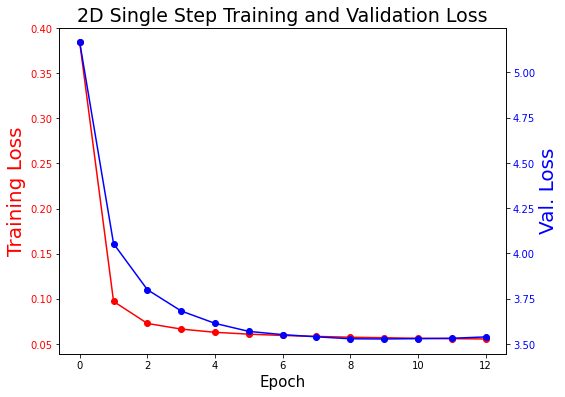

In [ ]:
plot_loss(history=single_step_2D_history, title='2D Single Step Training and Validation Loss')
del single_step_2D_history

In [ ]:
#Checking sample prediction shape
for x,y in val_single_2D.take(1):
  print(single_step_2D_model.predict(x).shape)

(256, 1)


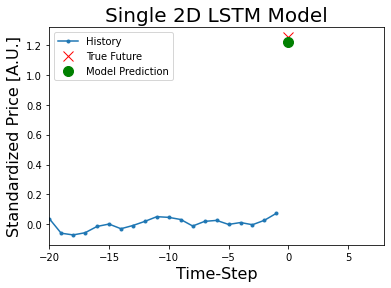

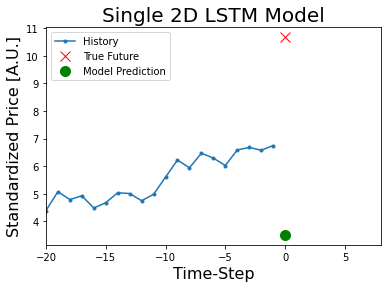

In [ ]:
for x,y in val_single_2D.take(2):
  plot = plot_short_pred(plot_data=[x[0][:,1].numpy(), y[0].numpy(), single_step_2D_model.predict(x)[0]], delta=0, title='Single 2D LSTM Model')
  plot.show()

In [ ]:
#delete model
del single_step_2D_model

### Creación del modelo, entrenamiento, predicción y eliminación del modelo con 128 neuronas en su capa intermedia.

In [ ]:
%%time
#CREATING MODEL
tf.keras.backend.clear_session()
single_step_2D_model = my_model(n_of_neurons=128, in_shape=x_train_single_2D.shape[-2:])
single_step_2D_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

#TRAINING
P=3
early_stopping = EarlyStopping(monitor="val_loss", patience=P, restore_best_weights=True)
#In my opinion "single_step_history" should be named as "single_step_fit"
single_step_2D_history = single_step_2D_model.fit(train_single_2D, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data = val_single_2D, callbacks=[early_stopping],
                                            validation_steps=EVALUATION_INTERVAL)

#PREDICTIONS
predictions128U = single_step_2D_model.predict(x_val_single_2D)

#deleting model
del single_step_2D_model

Epoch 1/100
200/200 [==============================] - 3s 8ms/step - loss: 0.1158 - val_loss: 1.8185
Epoch 2/100
200/200 [==============================] - 1s 6ms/step - loss: 0.0780 - val_loss: 1.5691
Epoch 3/100
200/200 [==============================] - 1s 6ms/step - loss: 0.0693 - val_loss: 1.6181
Epoch 4/100
200/200 [==============================] - 1s 6ms/step - loss: 0.0644 - val_loss: 1.8748
Epoch 5/100
200/200 [==============================] - 1s 6ms/step - loss: 0.0613 - val_loss: 1.9485
CPU times: user 9.94 s, sys: 743 ms, total: 10.7 s
Wall time: 8.65 s


### Gráfica de la pérdida en función de las epochs

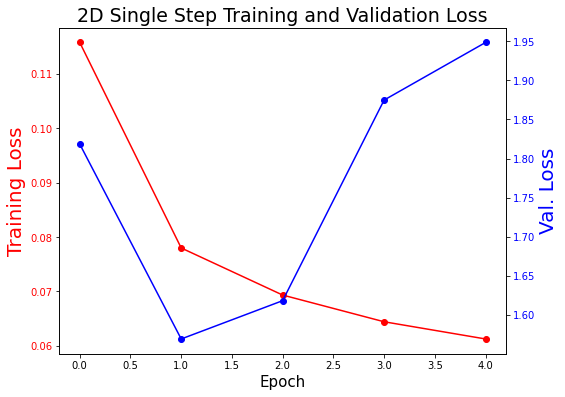

In [ ]:
plot_loss(history=single_step_2D_history, title='2D Single Step Training and Validation Loss')
del single_step_2D_history

### Creación del modelo, entrenamiento, predicción y eliminación del modelo con 256 neuronas en su capa intermedia.

In [ ]:
%%time
#CREATING MODEL
tf.keras.backend.clear_session()
single_step_2D_model = my_model(n_of_neurons=256, in_shape=x_train_single_2D.shape[-2:])
single_step_2D_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

#TRAINING
P=3
early_stopping = EarlyStopping(monitor="val_loss", patience=P, restore_best_weights=True)
#In my opinion "single_step_history" should be named as "single_step_fit"
single_step_2D_history = single_step_2D_model.fit(train_single_2D, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data = val_single_2D, callbacks=[early_stopping], 
                                            validation_steps=EVALUATION_INTERVAL)

#PREDICTIONS
predictions256U = single_step_2D_model.predict(x_val_single_2D)

#deleting model
del single_step_2D_model

Epoch 1/100
200/200 [==============================] - 3s 10ms/step - loss: 0.1246 - val_loss: 1.5376
Epoch 2/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0822 - val_loss: 1.0196
Epoch 3/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0720 - val_loss: 0.9269
Epoch 4/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0663 - val_loss: 1.5410
Epoch 5/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0629 - val_loss: 1.3466
Epoch 6/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0602 - val_loss: 1.8522
CPU times: user 12.3 s, sys: 837 ms, total: 13.1 s
Wall time: 12.1 s


### Gráfica de la pérdida en función de las epochs

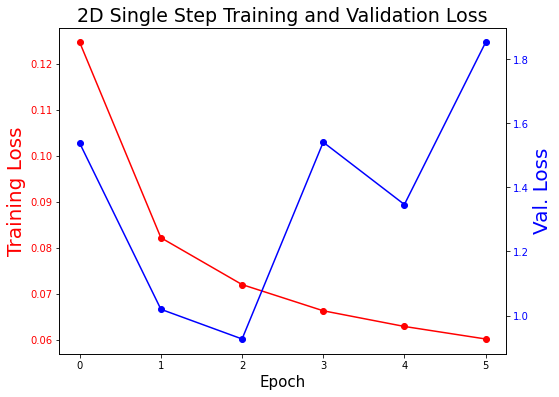

In [ ]:
plot_loss(history=single_step_2D_history, title='2D Single Step Training and Validation Loss')
del single_step_2D_history

<a name="1stPredPlots"></a>
# Primeras gráficas: Graficando predicciones (8, 128 y 256 neuronas) y mostrando errores (MSE)
- Gráficas de las predicciones de los modelos hechos anteriormente.

Volver a [Tabla de contenidos](#contents).

### Configurando dataframes para obtener series de tiempo (y no solo arrays):

In [ ]:
#To plot part of the train and validation data (from BTC only) together with models predictions

#------- Creating dframes (to work with time series) with standirized data
#dframes lengths
N = len(features)
M = len(predictions8U)
#print(N)
#print(M)

#data dataframe
data_std = pd.DataFrame(index=data.index, columns=['AdjCloStd'])
train_part = data_std[:TRAIN_SPLIT] #Not all train data, but just bitcoin train data
valid = data_std[TRAIN_SPLIT:]
#print(train_part)

#predictions dataframe
predictions = pd.DataFrame(index=data.tail(M).index, columns=['Pred8U','Pred128U','Pred256U'])

#print(features['BTC-USD'][1])
#Filling data dataframe
for i in range(0,N):
  data_std['AdjCloStd'][i] = dataset[:,0][i]#features['BTC-USD'][i]#uni_data#0 column is for btc_usd#

#print(train_part)
#print(data_std)
#NOTE: it is strange to me that train_part has something and it was not filled explicitely

#Filling predictions dataframe
predictions['Pred8U'] = predictions8U
predictions['Pred128U'] = predictions128U
predictions['Pred256U'] = predictions256U

### Graficando serie de tiempo y predicciones:

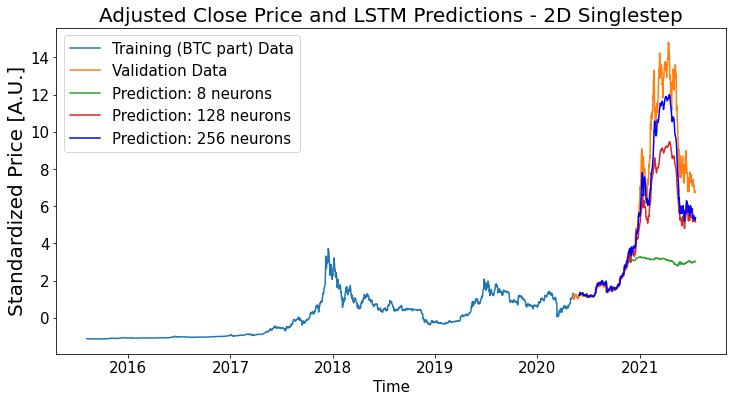

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(train_part['AdjCloStd'], label="Training (BTC part) Data")
plt.plot(valid['AdjCloStd'], label="Validation Data")
plt.plot(predictions['Pred8U'], label="Prediction: 8 neurons")
plt.plot(predictions['Pred128U'], label="Prediction: 128 neurons")
plt.plot(predictions['Pred256U'], label="Prediction: 256 neurons", color='blue')
plt.title("Adjusted Close Price and LSTM Predictions - 2D Singlestep", size=20)
plt.ylabel("Standardized Price [A.U.]", size=20)
plt.xlabel("Time", size=15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

### Graficando datos de validación y predicciones

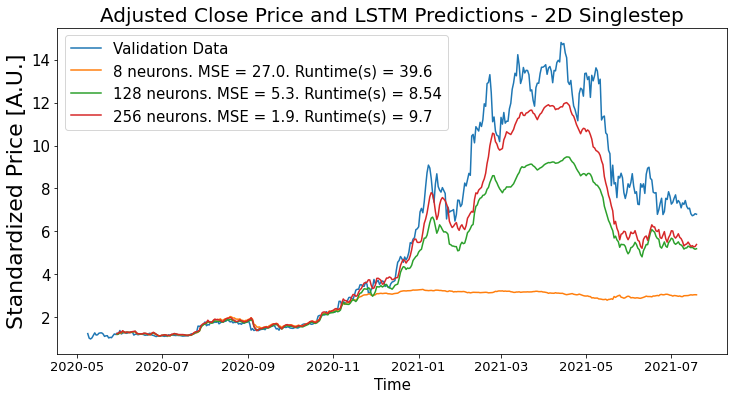

In [ ]:
#training time
T_8U = 39.6
T_128U = 8.54
T_256U = 9.7

#MSE Calculations
MSE_8U = round(mean_squared_error(y_val_single_2D, predictions8U , squared=True),1)
MSE_128U = round(mean_squared_error(y_val_single_2D, predictions128U , squared=True),1)
MSE_256U = round(mean_squared_error(y_val_single_2D, predictions256U, squared=True),1)

#Plotting
plt.figure(figsize=(12,6))
plt.plot(valid['AdjCloStd'], label="Validation Data")
plt.plot(predictions['Pred8U'], label="8 neurons. MSE = "+str(MSE_8U)+". Runtime(s) = "+str(T_8U))
plt.plot(predictions['Pred128U'], label="128 neurons. MSE = "+str(MSE_128U)+". Runtime(s) = "+str(T_128U))
plt.plot(predictions['Pred256U'], label="256 neurons. MSE = "+str(MSE_256U)+". Runtime(s) = "+str(T_256U))
plt.title("Adjusted Close Price and LSTM Predictions - 2D Singlestep", size=20)
plt.ylabel("Standardized Price [A.U.]", size=22)
plt.xlabel("Time", size=15)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)
plt.show()
#NOTE: Destadarization NOT DONE

<a name="sameModels"></a>
# SEGUNDOS MODELOS (PROBLEMA): Predicciones de modelos "iguales" (con 256 y 2048 neuronas)
- Se muestran gráficas de predicciones de 6 modelos: 3 con 256 neuronas y 3 con 2048.
- Nota: Ya no se observa que desde 2048 hacia arriba el resultado de la predicción cambiara mucho al correr el modelo varias veces. Esto se puede deber a validation_steps=EVALUATION_INTERVAL, y no validation_steps=50 como se hizo inicialmente.

Volver a [Tabla de contenidos](#contents).

#Para 256 neuronas:


In [ ]:
%%time
tf.keras.backend.clear_session()
units=256
###################### 1ND MODEL ##################################
#CREATING MODEL
single_step_2D_model = my_model(n_of_neurons=units, in_shape=x_train_single_2D.shape[-2:])
single_step_2D_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

#TRAINING
P=3
early_stopping = EarlyStopping(monitor="val_loss", patience=P, restore_best_weights=True)
#In my opinion "single_step_history" should be named as "single_step_fit"
single_step_2D_history = single_step_2D_model.fit(train_single_2D, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data = val_single_2D, callbacks=[early_stopping], 
                                            validation_steps=EVALUATION_INTERVAL)

#PREDICTIONS
predictions256U_1 = single_step_2D_model.predict(x_val_single_2D)

#deleting model
del single_step_2D_model, single_step_2D_history

###################### 2ND MODEL ##################################
tf.keras.backend.clear_session()
#CREATING MODEL
single_step_2D_model = my_model(n_of_neurons=units, in_shape=x_train_single_2D.shape[-2:])
single_step_2D_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

#TRAINING
P=3
early_stopping = EarlyStopping(monitor="val_loss", patience=P, restore_best_weights=True)
#In my opinion "single_step_history" should be named as "single_step_fit"
single_step_2D_history = single_step_2D_model.fit(train_single_2D, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data = val_single_2D, callbacks=[early_stopping],
                                            validation_steps=EVALUATION_INTERVAL)

#PREDICTIONS
predictions256U_2 = single_step_2D_model.predict(x_val_single_2D)

#deleting model
del single_step_2D_model, single_step_2D_history

###################### 3RD MODEL ##################################
tf.keras.backend.clear_session()
#CREATING MODEL
single_step_2D_model = my_model(n_of_neurons=units, in_shape=x_train_single_2D.shape[-2:])
single_step_2D_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

#TRAINING
P=3
early_stopping = EarlyStopping(monitor="val_loss", patience=P, restore_best_weights=True)
#In my opinion "single_step_history" should be named as "single_step_fit"
single_step_2D_history = single_step_2D_model.fit(train_single_2D, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data = val_single_2D, callbacks=[early_stopping],
                                            validation_steps=EVALUATION_INTERVAL)

#PREDICTIONS
predictions256U_3 = single_step_2D_model.predict(x_val_single_2D)

#deleting model
del single_step_2D_model, single_step_2D_history

Epoch 1/100
200/200 [==============================] - 4s 10ms/step - loss: 0.1227 - val_loss: 1.5086
Epoch 2/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0809 - val_loss: 1.4943
Epoch 3/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0713 - val_loss: 1.0474
Epoch 4/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0659 - val_loss: 1.5485
Epoch 5/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0628 - val_loss: 1.3717
Epoch 6/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0598 - val_loss: 1.5745
Epoch 1/100
200/200 [==============================] - 4s 11ms/step - loss: 0.1250 - val_loss: 1.5029
Epoch 2/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0826 - val_loss: 1.8425
Epoch 3/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0725 - val_loss: 1.3518
Epoch 4/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0664 - val_l

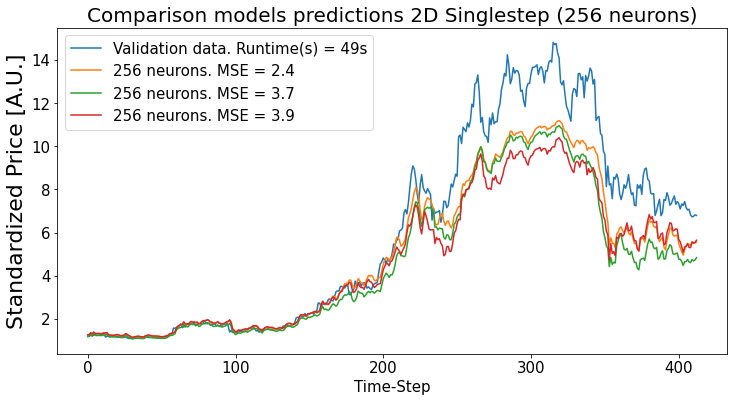

In [ ]:
###################### PLOTTING ##################################
#MSE Calculations
MSE_256U_1 = round(mean_squared_error(y_val_single_2D, predictions256U_1 , squared=True),1)
MSE_256U_2 = round(mean_squared_error(y_val_single_2D, predictions256U_2 , squared=True),1)
MSE_256U_3 = round(mean_squared_error(y_val_single_2D, predictions256U_3 , squared=True),1) 


#Plotting
plt.figure(figsize=(12,6))
plt.plot(y_val_single_2D, label="Validation data. Runtime(s) = 49s")
plt.plot(predictions256U_1, label="256 neurons. MSE = "+str(MSE_256U_1))
plt.plot(predictions256U_2, label="256 neurons. MSE = "+str(MSE_256U_2))
plt.plot(predictions256U_3, label="256 neurons. MSE = "+str(MSE_256U_3))
plt.title("Comparison models predictions 2D Singlestep (256 neurons)", size=20)
plt.ylabel("Standardized Price [A.U.]", size=22)
plt.xlabel("Time-Step", size=15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

#Para 2048 neuronas (anteriormente problemático):


In [ ]:
%%time
tf.keras.backend.clear_session()
units=2048
###################### 1ND MODEL ##################################
#CREATING MODEL
single_step_2D_model = my_model(n_of_neurons=units, in_shape=x_train_single_2D.shape[-2:])
single_step_2D_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

#TRAINING
P=3
early_stopping = EarlyStopping(monitor="val_loss", patience=P, restore_best_weights=True)
#In my opinion "single_step_history" should be named as "single_step_fit"
single_step_2D_history = single_step_2D_model.fit(train_single_2D, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data = val_single_2D, callbacks=[early_stopping],
                                            validation_steps=EVALUATION_INTERVAL)

#PREDICTIONS
predictions2048U_1 = single_step_2D_model.predict(x_val_single_2D)

#deleting model
del single_step_2D_model, single_step_2D_history

###################### 2ND MODEL ##################################
tf.keras.backend.clear_session()
#CREATING MODEL
single_step_2D_model = my_model(n_of_neurons=units, in_shape=x_train_single_2D.shape[-2:])
single_step_2D_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

#TRAINING
P=3
early_stopping = EarlyStopping(monitor="val_loss", patience=P, restore_best_weights=True)
#In my opinion "single_step_history" should be named as "single_step_fit"
single_step_2D_history = single_step_2D_model.fit(train_single_2D, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data = val_single_2D, callbacks=[early_stopping],
                                            validation_steps=EVALUATION_INTERVAL)

#PREDICTIONS
predictions2048U_2 = single_step_2D_model.predict(x_val_single_2D)

#deleting model
del single_step_2D_model, single_step_2D_history

###################### 3RD MODEL ##################################
tf.keras.backend.clear_session()
#CREATING MODEL
single_step_2D_model = my_model(n_of_neurons=units, in_shape=x_train_single_2D.shape[-2:])
single_step_2D_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

#TRAINING
P=3
early_stopping = EarlyStopping(monitor="val_loss", patience=P, restore_best_weights=True)
#In my opinion "single_step_history" should be named as "single_step_fit"
single_step_2D_history = single_step_2D_model.fit(train_single_2D, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data = val_single_2D, callbacks=[early_stopping],
                                            validation_steps=EVALUATION_INTERVAL)

#PREDICTIONS
predictions2048U_3 = single_step_2D_model.predict(x_val_single_2D)

#deleting model
del single_step_2D_model, single_step_2D_history

Epoch 1/100
200/200 [==============================] - 44s 214ms/step - loss: 0.6489 - val_loss: 2.0504
Epoch 2/100
200/200 [==============================] - 40s 201ms/step - loss: 0.1383 - val_loss: 1.2269
Epoch 3/100
200/200 [==============================] - 41s 205ms/step - loss: 0.0954 - val_loss: 1.7721
Epoch 4/100
200/200 [==============================] - 41s 205ms/step - loss: 0.0819 - val_loss: 1.4939
Epoch 5/100
200/200 [==============================] - 41s 204ms/step - loss: 0.0739 - val_loss: 1.2291
Epoch 1/100
200/200 [==============================] - 43s 208ms/step - loss: 0.6304 - val_loss: 3.4356
Epoch 2/100
200/200 [==============================] - 41s 203ms/step - loss: 0.1299 - val_loss: 1.1383
Epoch 3/100
200/200 [==============================] - 41s 204ms/step - loss: 0.0842 - val_loss: 1.8764
Epoch 4/100
200/200 [==============================] - 41s 205ms/step - loss: 0.0763 - val_loss: 1.8910
Epoch 5/100
200/200 [==============================] - 41s 205ms

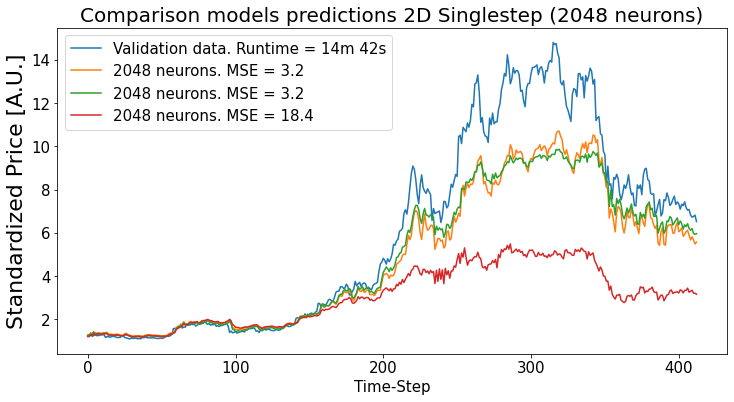

In [ ]:
###################### PLOTTING ##################################
#MSE Calculations
MSE_2048U_1 = round(mean_squared_error(y_val_single_2D, predictions2048U_1 , squared=True),1)
MSE_2048U_2 = round(mean_squared_error(y_val_single_2D, predictions2048U_2 , squared=True),1)
MSE_2048U_3 = round(mean_squared_error(y_val_single_2D, predictions2048U_3 , squared=True),1) 


#Plotting
plt.figure(figsize=(12,6))
#plt.plot(valid['AdjCloStd'], label="Validation Data")
plt.plot(y_val_single_2D, label="Validation data. Runtime = 14m 42s")
plt.plot(predictions2048U_1, label="2048 neurons. MSE = "+str(MSE_2048U_1))
plt.plot(predictions2048U_2, label="2048 neurons. MSE = "+str(MSE_2048U_2))
plt.plot(predictions2048U_3, label="2048 neurons. MSE = "+str(MSE_2048U_3))
plt.title("Comparison models predictions 2D Singlestep (2048 neurons)", size=20)
plt.ylabel("Standardized Price [A.U.]", size=22)
plt.xlabel("Time-Step", size=15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

<a name="Errors"></a>

#Caracterizando el error (MSE) con modelos bivariados de 256 neuronas
- Se hicieron 100 número de simulaciones y se guardó el valor del MSE de cada simulación (en la variable errors).
- Histograma de los errores.
- Pruebas de normalidad.
- Bootstap (intervalo de confianza).

Volver a [Tabla de contenidos](#contents).

In [ ]:
%%time
N_SIM = 100
errors256_2D = []
for i in range(N_SIM):
  print("Simulation:"+str(i))
  tf.keras.backend.clear_session()
  #CREATING MODEL
  single_step_2D_model = my_model(n_of_neurons=256, in_shape=x_train_single_2D.shape[-2:])
  single_step_2D_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
  
  #TRAINING
  P=3
  early_stopping = EarlyStopping(monitor="val_loss", patience=P, restore_best_weights=True)
  #In my opinion "single_step_history" should be named as "single_step_fit"
  single_step_2D_history = single_step_2D_model.fit(train_single_2D, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                                              validation_data = val_single_2D, callbacks=[early_stopping],
                                              validation_steps=EVALUATION_INTERVAL)

  #PREDICTIONS
  predictions256U = single_step_2D_model.predict(x_val_single_2D)

  #Calculating and saving errorsNOTDONE
  MSE = round(mean_squared_error(y_val_single_2D, predictions256U , squared=True),2)
  errors256_2D.append(MSE)

  #deleting model
  del single_step_2D_model, single_step_2D_history

print(errors256_2D)

Simulation:0
Epoch 1/100
200/200 [==============================] - 3s 10ms/step - loss: 0.1319 - val_loss: 1.6618
Epoch 2/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0827 - val_loss: 1.3386
Epoch 3/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0729 - val_loss: 1.2607
Epoch 4/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0668 - val_loss: 1.2724
Epoch 5/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0631 - val_loss: 1.6165
Epoch 6/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0608 - val_loss: 1.6542
Simulation:1
Epoch 1/100
200/200 [==============================] - 3s 10ms/step - loss: 0.1289 - val_loss: 1.2036
Epoch 2/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0819 - val_loss: 1.2992
Epoch 3/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0719 - val_loss: 1.6374
Epoch 4/100
200/200 [==============================] - 2s 8ms/s

---------- Histograma ----------


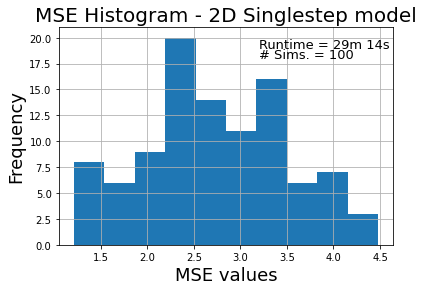

---------- Normality tests ----------
Shapiro-Wilk p-value for MSE:  0.47263944149017334
Kolmogorov-Smirnov p-value for MSE:  1.5121564060637515e-97
---------- Bootstrap ----------
2.7286999999999995
[2.581  2.8775]
0.2964999999999991


In [ ]:
#Errors
print("---------- Histograma ----------")
xt = 3.2
#errors256_2D = [3.22, 3.18, 1.37, 2.39, 4.06, 2.1, 1.77, 2.18, 1.68, 1.21, 1.49, 3.83, 1.3, 2.22, 1.38, 3.27, 2.72, 2.92, 3.83, 3.35, 2.31, 3.57, 2.83, 3.22, 3.04, 2.76, 3.91, 3.94, 2.32, 2.24, 1.81, 3.44, 2.02, 2.41, 1.87, 4.34, 2.84, 2.42, 2.38, 3.4, 3.54, 3.11, 3.05, 3.95, 2.54, 1.79, 2.24, 2.95, 2.56, 2.89, 3.38, 2.8, 3.7, 3.2, 2.38, 2.4, 2.72, 2.45, 2.28, 2.02, 2.08, 2.46, 2.63, 2.53, 2.7, 3.62, 4.25, 2.77, 1.38, 2.98, 4.48, 3.58, 2.31, 3.33, 2.51, 2.03, 3.79, 2.5, 2.53, 3.19, 2.8, 2.14, 1.38, 3.9, 2.92, 2.9, 3.24, 3.38, 2.86, 1.84, 3.39, 2.51, 2.39, 2.29, 3.22, 1.86, 3.21, 2.05, 1.3, 3.15]
plt.hist(errors256_2D)
#plt.title("Histograma de los Errores Cuadráticos Medios de Modelos 2D")
#plt.ylabel("Cuentas")
#plt.xlabel("Valores de MSE")
plt.title("MSE Histogram - 2D Singlestep model", size = 20)
plt.ylabel("Frequency", size = 18)
plt.xlabel("MSE values", size = 18)
plt.text(xt, 19, "Runtime = 29m 14s", size = 13)
plt.text(xt, 18, "# Sims. = 100", size = 13)
plt.grid(True)
plt.show()

print("---------- Normality tests ----------")
staE, pvalE = stats.shapiro(errors256_2D)
print("Shapiro-Wilk p-value for MSE: ",pvalE)
staE, pvalE = stats.kstest(errors256_2D,'norm')
print("Kolmogorov-Smirnov p-value for MSE: ",pvalE)

print("---------- Bootstrap ----------")
random.seed(10)
bs_reps = dcst.draw_bs_reps(errors256_2D, np.mean, size = 10000)
conf_int = np.percentile(bs_reps, [2.5, 97.5])
print(np.mean(errors256_2D))
#print(np.median(errors256))
print(conf_int)
#print(conf_int-np.mean(errors256))
print(conf_int[1]-conf_int[0])

<a name="Conclu"></a>
#Conclusiones e ideas
### Conclusiones:
1. El modelo logra mejores predicciones cuando tiene mas neuronas en su capa intermedia hasta las 512 neuronas.
2. Los resultados de las predicciones no son 100% repetibles. 
3. El intervalo de confianza (con un nivel de confianza del 95%) para la media del error de la predicción de las series bidimensionales a un paso en un modelo con 256 neuronas en su capa intermedia es 2.72 +/- (2.58, 2.87) con un $\Delta$Error = 0.29.
4. El modelo unidimensional arroja mejores predicciones que el modelo bidimensional. Este resultado es contrario al que se esperaba obtener.

### Ideas:
1. Organizar al principio del documento 2 o 3 celdas donde se cargen la funciones y las variables necesarias para trabajar (de datos y de gráficas), y que no haya que cargar tantas celdas para poder correr los modelos (y también hacerlo en el cuaderno del análisis univariado).

Volver a [Tabla de contenidos](#contents).





## Bibliografía

### Redes RNN-LSTM (cuaderno).
1. [Introducción a Keras LSTM para series de tiempo multivariadas. Montenegro et.al.](https://nbviewer.jupyter.org/github/AprendizajeProfundo/Diplomado/blob/master/Temas/M%C3%B3dulo%205-%20Redes%20recurrentes/Cuadernos/rnrTimes_series_Multivariate.ipynb).
1. A. [Keras Timeseries Multi-Step Multi-Output](https://www.kaggle.com/nicapotato/keras-timeseries-multi-step-multi-output).

### Yahoo Finance (datos importados).
2. [Yahoo Finance API – A Complete Guide](https://algotrading101.com/learn/yahoo-finance-api-guide/)
3. [yfinance Library – A Complete Guide](https://algotrading101.com/learn/yfinance-guide/)
4. [yfinance documentation](https://pypi.org/project/yfinance/)

